In [2]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import preprocess_input
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [3]:
image_width = 224
image_height = 224

# Change batchsize
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/train/"
test_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/test/"

traditional_feature_train_loc = 'D:/retinal_data_set_visioncare/traditional_features/train/traditional_features.csv'
traditional_feature_test_loc = 'D:/retinal_data_set_visioncare/traditional_features/test/traditional_features.csv'

vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [4]:
x = vgg16_base.get_layer(index=-1).output
feature_extraction_layer = GlobalAveragePooling2D()(x)
model = Model(inputs=vgg16_base.input, outputs=feature_extraction_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
# Get all the classes from the original train directory
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

# keep features with its corrosponding file names as dictionary
# train_features = {}
# test_features = {}

In [6]:
train_classes

['0', '1', '2', '3', '4']

In [6]:
# def create_traditional_features(data_dir, file_path):
#     COLUMN_NAMES=['Relative_path','Microaneurysms','Retinal_haemorrhages','Exudates','NV', 'Photocoagulation', 'Vitreous_hemorrhages', 'TRD']
#     df = pd.DataFrame(columns=COLUMN_NAMES)
    
#     for idx, level in enumerate(train_classes):
#         retina_root = data_dir + level + '/'
#         retina_root_list = os.listdir(retina_root)

#         for index, relative_path in enumerate(retina_root_list):
#             if relative_path == 'Thumbs.db':
#                 continue
#             source = retina_root + relative_path
#             #print(relative_path.split('.')[0])
#             image_name = relative_path.split('.')[0]
#             if level == '0':
#                 df = df.append({'Relative_path': image_name, 'Microaneurysms': 0, 'Retinal_hemorrhages': 0, 'Exudates': 0, 'NV': 0, 'Photocoagulation': 0, 'Vitreous_hemorrhages': 0, 'TRD': 0}, ignore_index=True)
#             elif level == '1':
#                 df = df.append({'Relative_path': image_name, 'Microaneurysms': 1, 'Retinal_hemorrhages': 0, 'Exudates': 0, 'NV': 0, 'Photocoagulation': 0, 'Vitreous_hemorrhages': 0, 'TRD': 0}, ignore_index=True)
#             elif level == '2':
#                 df = df.append({'Relative_path': image_name, 'Microaneurysms': 2, 'Retinal_hemorrhages': 2, 'Exudates': 1, 'NV': 0, 'Photocoagulation': 0, 'Vitreous_hemorrhages': 0, 'TRD': 0}, ignore_index=True)
#             elif level == '3':
#                 df = df.append({'Relative_path': image_name, 'Microaneurysms': 3, 'Retinal_hemorrhages': 3, 'Exudates': 2, 'NV': 0, 'Photocoagulation': 0, 'Vitreous_hemorrhages': 0, 'TRD': 0}, ignore_index=True)
#             else:
#                 df = df.append({'Relative_path': image_name, 'Microaneurysms': 3, 'Retinal_hemorrhages': 3, 'Exudates': 2, 'NV': 1, 'Photocoagulation': 0, 'Vitreous_hemorrhages': 0, 'TRD': 0}, ignore_index=True)
                
#     df.to_csv(file_path, encoding='utf-8', index=False)

In [7]:
# create_traditional_features(train_dir, traditional_feature_train_loc)
# create_traditional_features(test_dir, traditional_feature_test_loc)

In [7]:
train_traditional_feature_df = pd.read_csv(traditional_feature_train_loc)
test_traditional_feature_df = pd.read_csv(traditional_feature_test_loc)

In [8]:
test_traditional_feature_df.tail(5)

,Relative_path,Microaneurysms,Retinal_hemorrhages,Exudates,NV,Photocoagulation,Vitreous_hemorrhages,TRD
181,37117_left,3,3,1,1,0,1,0
182,4793_left,3,3,2,1,0,1,0
183,6719_right,3,1,1,1,0,1,0
184,8950_left,3,2,1,1,1,0,0
185,IDRiD_022,3,3,2,1,0,1,0


In [9]:
def generate_XY(data_dir, traditional_feature_df, size=224):
    combined_feature_list = []
    labels = []

    for idx, level in enumerate(train_classes):
        retina_root = data_dir + level + '/'
        retina_root_list = os.listdir(retina_root)

        for index, relative_path in enumerate(retina_root_list):
            if relative_path == 'Thumbs.db':
                continue
            source = retina_root + relative_path
            img = image.load_img(source, target_size=(image_width, image_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            # get the features 
            extract_features = model.predict(x)
            flat = extract_features.flatten()

            image_name = relative_path.split('.')[0]
            traditional_row = traditional_feature_df.loc[traditional_feature_df['Relative_path'] == image_name]
            traditional_feature_vector = []
            traditional_feature_vector.append(traditional_row.iloc[0].Microaneurysms)
            traditional_feature_vector.append(traditional_row.iloc[0].Retinal_hemorrhages)
            traditional_feature_vector.append(traditional_row.iloc[0].Exudates)
            traditional_feature_vector.append(traditional_row.iloc[0].NV)
            traditional_feature_vector.append(traditional_row.iloc[0].Photocoagulation)
            traditional_feature_vector.append(traditional_row.iloc[0].Vitreous_hemorrhages)
            traditional_feature_vector.append(traditional_row.iloc[0].TRD)
            flat = np.append(flat, traditional_feature_vector)
            combined_feature_list.append(flat)
            labels.append(int(level))
    #         combined_feature_list.append({'feature':flat, 'label':level})
            
    return np.array(combined_feature_list), np.array(labels)
    

In [10]:
X_train, y_train = generate_XY(train_dir, train_traditional_feature_df)
X_test, y_test = generate_XY(test_dir, test_traditional_feature_df)

In [11]:
X_train.shape

(741, 519)

In [12]:
X_train[0][512]

0.0

In [13]:
idx_categorical_columns = [512, 513, 514, 515, 516, 517, 518]
idx_neumerical_columns = [i for i in range(np.shape(X_train)[1]) if i not in idx_categorical_columns]

In [14]:
# extract categorical ordinal attributes from training data
X_train_categorical = X_train[:,idx_categorical_columns]
# extract neumerical attributes from training data
X_train_neumeric = X_train[:, idx_neumerical_columns]
# extract categorical ordinal attributes from test data
X_test_categorical = X_test[:,idx_categorical_columns]
# extract neumerical attributes from test data
X_test_neumeric = X_test[:, idx_neumerical_columns]

In [15]:
X_train_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 3., 1., ..., 0., 0., 1.],
       [3., 3., 1., ..., 0., 1., 1.],
       [3., 3., 2., ..., 0., 0., 0.]])

In [16]:
# Feature Scaling - fature normalizing only for extracted neumeric features
scaler = StandardScaler()
X_train_neumeric = scaler.fit_transform(X_train_neumeric)
X_test_neumeric = scaler.transform(X_test_neumeric)

In [17]:
# Make sparse matrix
X_sparse = csr_matrix(X_train_neumeric)

In [18]:
# Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_train_neumeric)

In [19]:
# list of explained variance ratios
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(tsvd_var_ratios)

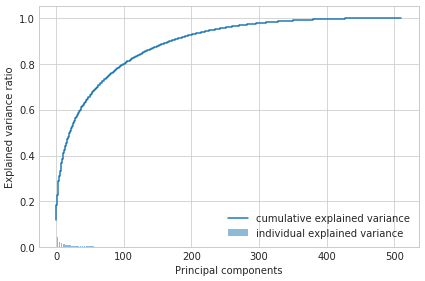

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(tsvd_var_ratios)), tsvd_var_ratios, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [21]:
# Create Function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [22]:
# Run function
number_of_components = select_n_components(tsvd_var_ratios, 0.95)

In [23]:
number_of_components

237

In [24]:
truncated_opt_svd = TruncatedSVD(n_components=number_of_components, random_state=42)
transformed_X_train_neumeric = truncated_opt_svd.fit_transform(X_train_neumeric)
transformed_X_test_neumeric = truncated_opt_svd.transform(X_test_neumeric)

In [25]:
X_train = np.concatenate((transformed_X_train_neumeric, X_train_categorical),axis=1)
X_test = np.concatenate((transformed_X_test_neumeric, X_test_categorical),axis=1)

In [26]:
X_train.shape[1]

244

In [27]:
X = X_train
#X = transformed_data
Y = y_train

In [28]:
len(X[0])

244

In [29]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [30]:
class_weight_dic = dict(enumerate(class_weight))

In [31]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = X_train.shape[1]

cross_model = Sequential()
cross_model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('relu'))
cross_model.add(Dropout(0.8))
cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('softmax'))

cross_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [32]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 100.00%
AVG Validation Acc : 94.75%
Validation precision - mean: 0.931838, stddev: 0.079511
Validation recall - mean: 0.923910, stddev: 0.089915
Validation f-score - mean: 0.925439, stddev: 0.073609
Confusion matrix:
[[7.828e+01 1.240e+00 8.000e-02 0.000e+00 0.000e+00]
 [2.720e+00 1.628e+01 4.000e-01 0.000e+00 0.000e+00]
 [4.000e-02 3.200e-01 2.224e+01 9.200e-01 2.800e-01]
 [0.000e+00 0.000e+00 5.600e-01 9.520e+00 1.200e-01]
 [0.000e+00 4.000e-02 4.000e-01 6.800e-01 1.408e+01]]


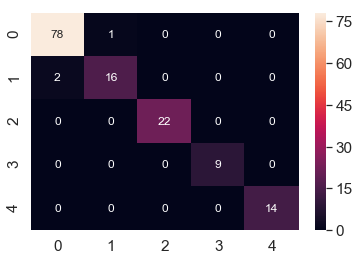

In [33]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [34]:
# Save the model
cross_model.save('D:/retinal_data_set_visioncare/models/vgg16/vgg16_traditional_and_deep_features_SVD_model.h5')

In [35]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = cross_model.predict(X_test)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
confusion_matrix_for_testset = confusion_matrix(y_test, Y_pred_for_test)
print(confusion_matrix(y_test, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(y_test, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[98  2  0  0  0]
 [ 7 17  1  0  0]
 [ 0  0 27  2  1]
 [ 0  0  3  8  2]
 [ 0  2  0  3 13]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.93      0.98      0.96       100
    mild-npdr       0.81      0.68      0.74        25
moderate-npdr       0.87      0.90      0.89        30
  severe-npdr       0.62      0.62      0.62        13
          pdr       0.81      0.72      0.76        18

  avg / total       0.87      0.88      0.87       186



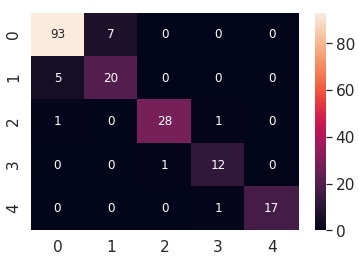

In [38]:
df_cm_test = pd.DataFrame(confusion_matrix_for_testset, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 12})# font size

sn.reset_orig()

In [40]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [41]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

loaded_cross_model = load_model('D:/retinal_data_set_visioncare/models/resnet18/resnet_traditional_and_deep_features_model.h5')

#convert original class labels to the one-hot-encoding
y_test = np_utils.to_categorical(y_test, 5)

Y_test_pred = loaded_cross_model.predict(X_test)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [42]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

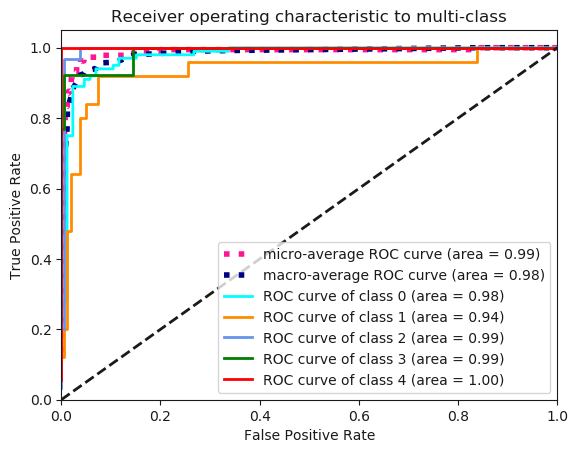

In [44]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

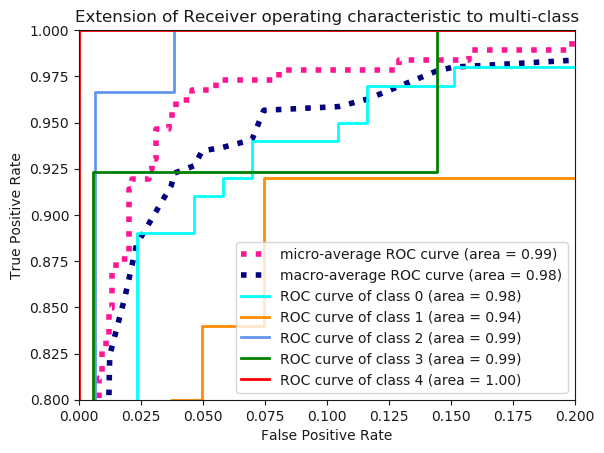

In [45]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()